# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done


# Importing packages

In [2]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# Scoring methods
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Preprocessing steps
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import decomposition

# Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [3]:
## Data loading functions. Uncomment the one you want to use
from worclipo.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')





The number of samples: 115
The number of columns: 494


## Creating a split in the data

A training and test set are created. The training set will be used to fit the classifier, while the test set is remained untouched until it is used for testing the trained classifier.

Split is stratified so labels are present in both sets in same proportions.

In [4]:
# Extract columns with labels
Y = data.pop('label').replace({'lipoma':0, 'liposarcoma':1}) #moeten we misschien nog ook de ID poppen?
print(f'The proportion of the labels is: {sum(Y)/len(Y)}')

# Extract the rest of the data (without the labels)
X = data
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, stratify=Y)

print(f'Size of training set: {X_train.shape}')
print(f'Size of test set: {X_test.shape}')

The proportion of the labels is: 0.5043478260869565
Size of training set: (92, 493)
Size of test set: (23, 493)


## Inspecting distribution of features
To determine data distribution of train set

### Visually inspect distribution of features

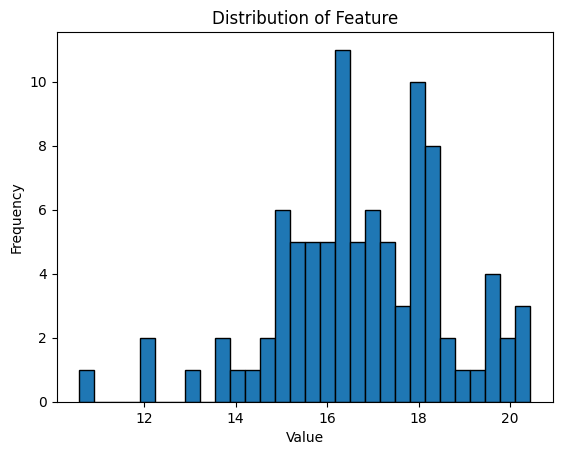

In [5]:
## UITEINDELIJK WEGHALEN DIT!!

#Check if Gaussian distribution per column
# if Gaussian distribution, take mean for filling empty cells (later in script)
# if not Gaussion distribution (and outliers or skewed), take median for filling empty cells (later in script)

# plt.hist(X_train.iloc[:, 15], bins=30, edgecolor='k') # Change number of colum to see distribution (between width dataframe)
plt.hist(X_train['PREDICT_original_tf_Gabor_entropy_F0.2_A1.57'], bins=30, edgecolor='k') # Change number of colum to see distribution (between width dataframe)


plt.title('Distribution of Feature')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# print(X_train.head())

## Preprocessing Data

### Missing Values
Determining cells with missing values and filling these

In [6]:
# Filling missing values with correct value based on type of distribution per column

# Definieer alpha voor de significantietest BEARGUMENTEREN WAAROM DEZE TEST IN REPORT + WAARDE
alpha = 0.05

# Initialiseer een teller voor normaal verdeelde kolommen
normal_distributed_columns_count = 0
not_normal_distributed_columns_count = 0
nans_found_in_column_count = 0

# Loop door elke kolom in de DataFrame en voer Shapiro-Wilk test uit
for column in X_train:
    stat, p = shapiro(X_train[column])
    if p > alpha:
        # print(column)
        normal_distributed_columns_count += 1  # Tel kolom als normaal verdeeld
        if X_train[column].isna().sum() > 0:
            X_train[column].fillna(X_train[column].mean)
            nans_found_in_column_count += 1
    else:
        not_normal_distributed_columns_count += 1  # Tel kolom als normaal verdeeld
        if X_train[column].isna().sum() > 0:
            X_train[column].fillna(X_train[column].median)
            nans_found_in_column_count += 1

print(f'The number of normal distributed columns is: {normal_distributed_columns_count}')
print(f'The number of not normal distributed columns is: {not_normal_distributed_columns_count}')
print(f'The number of columns where nans were filled: {nans_found_in_column_count}')

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


The number of normal distributed columns is: 82
The number of not normal distributed columns is: 411
The number of columns where nans were filled: 0


### Feature Scaling
Scale features in Train set

#### Motivation of chosen scaler

In [7]:
# Define counter for columns with many outliers
columns_with_many_outliers_count = 0

for column in X_train:
    Q1 = X_train[column].quantile(0.25)
    Q3 = X_train[column].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate number of outliers
    outliers = X_train[(X_train[column] < (Q1 - 1.5 * IQR)) | (X_train[column] > (Q3 + 1.5 * IQR))]
    outliers_count = outliers.shape[0]

    # Define what 'many' outliers mean
    if outliers_count > 0.05 * X_train.shape[0]:
        columns_with_many_outliers_count += 1
        # print(f"{column} has many outliers: {outliers_count} outliers")

print(f"Number of columns with many outliers: {columns_with_many_outliers_count}/{len(X_train.columns)}")


Number of columns with many outliers: 224/493


#### Scaling the data

In [8]:
# Initialize a RobustScaler object
scaler = RobustScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform both training and testing data using the scaler
X_train_sc = (scaler.transform(X_train))
X_test_sc = scaler.transform(X_test)

X_train_sc = pd.DataFrame(X_train_sc)
X_test_sc = pd.DataFrame(X_test_sc)

# Inspecting data

### Feature selection and extraction

In [9]:
# Zero variance
selector = VarianceThreshold(threshold=0)
vs_fit = selector.fit(X_train_sc)

X_train_zv = vs_fit.transform(X_train_sc)
X_test_zv = vs_fit.transform(X_test_sc)

# Willen we dit nou van train of test set weten?
print(f'Amount of features with zero variance: {X_train_sc.shape[1]-X_train_zv.shape[1]}')
print(f'Amount of features after removing features with zero variance: {X_train_zv.shape[1]}')

Amount of features with zero variance: 19
Amount of features after removing features with zero variance: 474


In [14]:
# Stel de KFold cross-validation in
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Voor elke k-waarde van 1 tot 10
for k in range(1, 11):
    print(f"\nEvaluating SelectKBest with k={k}")

    # Selecteer de k beste features
    selector = SelectKBest(f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_zv, Y_train)
    X_test_selected = selector.transform(X_test_zv)

    # Initialiseer de lijst om de nauwkeurigheden voor elke fold op te slaan
    accuracies = []

    # 10-fold cross-validation
    for train_index, test_index in kf.split(X_train_selected, Y_train):
        # Maak de subsets voor deze fold
        X_fold_train, X_fold_test = X_train_selected[train_index], X_train_selected[test_index]
        y_fold_train, y_fold_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

        # Train het kNN-model
        knn_model = KNeighborsClassifier()
        knn_model.fit(X_fold_train, y_fold_train)

        # Voorspel en evalueer de nauwkeurigheid
        predictions = knn_model.predict(X_fold_test)
        accuracy = accuracy_score(y_fold_test, predictions)
        accuracies.append(accuracy)

    # Print de gemiddelde nauwkeurigheid voor deze k
    average_accuracy = np.mean(accuracies)
    print(f"Average accuracy for k={k}: {average_accuracy}")


Evaluating SelectKBest with k=1
Average accuracy for k=1: 0.7411111111111112

Evaluating SelectKBest with k=2
Average accuracy for k=2: 0.7966666666666666

Evaluating SelectKBest with k=3
Average accuracy for k=3: 0.7633333333333333

Evaluating SelectKBest with k=4
Average accuracy for k=4: 0.7077777777777777

Evaluating SelectKBest with k=5
Average accuracy for k=5: 0.6977777777777778

Evaluating SelectKBest with k=6
Average accuracy for k=6: 0.6311111111111111

Evaluating SelectKBest with k=7
Average accuracy for k=7: 0.6955555555555555

Evaluating SelectKBest with k=8
Average accuracy for k=8: 0.6855555555555556

Evaluating SelectKBest with k=9
Average accuracy for k=9: 0.6733333333333335

Evaluating SelectKBest with k=10
Average accuracy for k=10: 0.6622222222222222


In [17]:
# Stel de StratifiedKFold cross-validation in
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lijst om de gemiddelde nauwkeurigheid en standaarddeviatie voor elk aantal componenten op te slaan
results = []

max_components = min(X_train_zv.shape[1], X_train_zv.shape[0] - 1)
for n_components in range(1, max_components + 1):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_zv)

    accuracies = []

    for train_index, test_index in skf.split(X_train_pca, Y_train):
        X_fold_train, X_fold_test = X_train_pca[train_index], X_train_pca[test_index]
        y_fold_train, y_fold_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

        knn_model = KNeighborsClassifier()
        knn_model.fit(X_fold_train, y_fold_train)

        predictions = knn_model.predict(X_fold_test)
        accuracy = accuracy_score(y_fold_test, predictions)
        accuracies.append(accuracy)

    average_accuracy = np.mean(accuracies)
    std_dev = np.std(accuracies)
    results.append((n_components, average_accuracy, std_dev))

# Sorteer de resultaten op nauwkeurigheid en print de top 5 met hun standaarddeviatie
top_results = sorted(results, key=lambda x: x[1], reverse=True)[:5]
for n_components, accuracy, std_dev in top_results:
    print(f"Top n_components={n_components}: Average accuracy = {accuracy} with std dev = {std_dev}")

Top n_components=1: Average accuracy = 0.6655555555555556 with std dev = 0.1879355024640628
Top n_components=4: Average accuracy = 0.6611111111111111 with std dev = 0.22636417724706517
Top n_components=6: Average accuracy = 0.6311111111111111 with std dev = 0.17103894582127874
Top n_components=3: Average accuracy = 0.63 with std dev = 0.1661510542834627
Top n_components=10: Average accuracy = 0.6288888888888888 with std dev = 0.20075167388567705


In [ ]:
# Feature selection using K best - ANOVA squared test
cv = StratifiedKfold(n_splits=10)

average_accuracies = []

fold_accuracies = []

for k in range(1,11):
    filter = SelectKBest(f_classif, k)

    for train_i, validatie_i
    X_train_fs = fs_chi.transform(X_train_zv)

    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X, y)

X_train_fs = fs_chi.transform(X_train_zv)
# X_test_fs = fs_chi.transform(X_test_zv)



print(X_train_fs.shape)
print(X_test_fs.shape)


(92, 5)
(23, 5)


In [ ]:
# # PCA
# # If there are more samples than features left after RFECV then perform PCA
# pca = decomposition.PCA(n_components=0.95)
# pca.fit(X_train_zv)
# X_train_fs = pca.transform(X_train_zv)
# X_test_fs = pca.transform(X_test_zv)

# Classifiers

In [ ]:
# General variables for classifiers
cv = 5

### KNN

In [ ]:
knn_model = KNeighborsClassifier()

# Define the parameter grid - WAAROM DEZE
param_grid_knn = {
    'n_neighbors': list(range(1, 60, 2)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1 for Manhattan distance, p=2 for Euclidean distance
}

# Create the grid search object with ROC AUC scoring
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=cv, scoring='roc_auc')

# Fit the grid search to the data
grid_search_knn.fit(X_train_fs, Y_train)

# Print the best parameters
print("Best parameters found: ", grid_search_knn.best_params_)

# Get the best estimator
best_knn_model = grid_search_knn.best_estimator_
print(f'Best estimator: {best_knn_model}')

# see how well model works on train and test data:
predictions_knn_train = best_knn_model.predict(X_train_fs)
print(classification_report(Y_train, predictions_knn_train))

roc_auc_knn_train = roc_auc_score(Y_train, predictions_knn_train)
print('ROC AUC =', roc_auc_knn_train)
accuracy_knn_train = accuracy_score(Y_train, predictions_knn_train)
print('Accuracy =', accuracy_knn_train)

predictions_knn_test = best_knn_model.predict(X_test_fs)
print(classification_report(Y_test, predictions_knn_test))

roc_auc_knn_test = roc_auc_score(Y_test, predictions_knn_test)
print('ROC AUC =', roc_auc_knn_test)
accuracy_knn_test = accuracy_score(Y_test, predictions_knn_test)
print('Accuracy =', accuracy_knn_test)

Best parameters found:  {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(weights='distance')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        46

    accuracy                           1.00        92
   macro avg       1.00      1.00      1.00        92
weighted avg       1.00      1.00      1.00        92

ROC AUC = 1.0
Accuracy = 1.0
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        11
           1       0.67      0.67      0.67        12

    accuracy                           0.65        23
   macro avg       0.65      0.65      0.65        23
weighted avg       0.65      0.65      0.65        23

ROC AUC = 0.6515151515151515
Accuracy = 0.6521739130434783


### Random forest

In [ ]:
#NB: runnen duurt lang door lijst aan n_estimators!

RF_model = RandomForestClassifier()

# Define the parameter grid - WAAROM DEZE
param_grid_RF = {
    #'n_estimators': list(range(1, 100, 10)), # more estimators probably better result but also more computationally expensive!
    'bootstrap': [True, False],
    'min_samples_leaf': list(range(1, 7, 2))
}

# Create the grid search object with ROC AUC scoring
grid_search_RF = GridSearchCV(RF_model, param_grid_RF, cv=cv, scoring='roc_auc', error_score='raise')

# Fit the grid search to the data
grid_search_RF.fit(X_train_fs, Y_train)

# Print the best parameters
print("Best parameters found: ", grid_search_RF.best_params_)

# Get the best estimator
best_RF_model = grid_search_RF.best_estimator_

print(best_RF_model)

# See how well model works on train and test data:
predictions_RF_train = best_RF_model.predict(X_train_fs)
print(classification_report(Y_train, predictions_RF_train))

roc_auc_RF_train = roc_auc_score(Y_train, predictions_RF_train)
print('ROC AUC =', roc_auc_RF_train)
accuracy_RF_train = accuracy_score(Y_train, predictions_RF_train)
print('Accuracy =', accuracy_RF_train)

predictions_RF_test = best_RF_model.predict(X_test_fs)
print(classification_report(Y_test, predictions_RF_test))

roc_auc_RF_test = roc_auc_score(Y_test, predictions_RF_test)
print('ROC AUC =', roc_auc_RF_test)
accuracy_RF_test = accuracy_score(Y_test, predictions_RF_test)
print('Accuracy =', accuracy_RF_test)

Best parameters found:  {'bootstrap': True, 'min_samples_leaf': 3}
RandomForestClassifier(min_samples_leaf=3)
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        46
           1       0.91      0.91      0.91        46

    accuracy                           0.91        92
   macro avg       0.91      0.91      0.91        92
weighted avg       0.91      0.91      0.91        92

ROC AUC = 0.9130434782608697
Accuracy = 0.9130434782608695
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.75      0.75      0.75        12

    accuracy                           0.74        23
   macro avg       0.74      0.74      0.74        23
weighted avg       0.74      0.74      0.74        23

ROC AUC = 0.7386363636363636
Accuracy = 0.7391304347826086


### Support Vector Machine

In [ ]:
# Define the SVM model
svm_model = svm.SVC(probability=True)

# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.01, 0.5, 1 ],  # Regularization parameter
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

# Create the grid search object with ROC AUC scoring
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=cv, scoring='roc_auc', error_score='raise')

# Fit the grid search to the data
grid_search_svm.fit(X_train_fs, Y_train)

# Print the best parameters
print("Best parameters found: ", grid_search_svm.best_params_)

# Get the best estimator
best_svm_model = grid_search_svm.best_estimator_

print(best_svm_model)

# See how well model works on train and test data
predictions_svm_train = best_svm_model.predict(X_train_fs)
print(classification_report(Y_train, predictions_svm_train))

roc_auc_svm_train = roc_auc_score(Y_train, predictions_svm_train)
print('ROC AUC =', roc_auc_svm_train)
accuracy_svm_train = accuracy_score(Y_train, predictions_svm_train)
print('Accuracy =', accuracy_svm_train)

predictions_svm_test = best_svm_model.predict(X_test_fs)
print(classification_report(Y_test, predictions_svm_test))

roc_auc_svm_test = roc_auc_score(Y_test, predictions_svm_test)
print('ROC AUC =', roc_auc_svm_test)
accuracy_svm_test = accuracy_score(Y_test, predictions_svm_test)
print('Accuracy =', accuracy_svm_test)

Best parameters found:  {'C': 1, 'gamma': 'scale'}
SVC(C=1, probability=True)
              precision    recall  f1-score   support

           0       0.76      0.85      0.80        46
           1       0.83      0.74      0.78        46

    accuracy                           0.79        92
   macro avg       0.80      0.79      0.79        92
weighted avg       0.80      0.79      0.79        92

ROC AUC = 0.7934782608695652
Accuracy = 0.7934782608695652
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.73      0.67      0.70        12

    accuracy                           0.70        23
   macro avg       0.70      0.70      0.70        23
weighted avg       0.70      0.70      0.70        23

ROC AUC = 0.696969696969697
Accuracy = 0.6956521739130435
